In [9]:
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import qutip as qt


In [10]:

def create_annihilation_operators(num_levels, num_qubits):
    """
    Create a list of annihilation operators for a system with a specified number of levels and qubits.
    
    Parameters:
    num_levels (int): Number of energy levels for each qubit.
    num_qubits (int): Number of qubits in the system.
    
    Returns:
    list: A list of annihilation operators for each qubit.
    """

    annihilation_operators = []

    a = qt.destroy(num_levels)

    for i in range(num_qubits):
        annihilation_operators.append(qt.tensor([a if j == i else qt.qeye(num_levels) for j in range(num_qubits)]))

    return annihilation_operators

In [11]:
def generate_basis(num_levels, num_qubits, num_particles):
    basis = [state for state in product(range(num_levels), repeat=num_qubits) if sum(state) == num_particles]
    return basis

In [12]:
def convert_to_reduced_hamiltonian(hamiltonian, num_levels, num_qubits, num_particles):
    """
    Convert a Hamiltonian to a reduced form for a system with a specified number of levels and qubits.
    
    Parameters:
    hamiltonian (qutip.Qobj): The original Hamiltonian.
    num_levels (int): Number of energy levels for each qubit.
    num_qubits (int): Number of qubits in the system.
    num_particles (int): Number of particles in the system.
    
    Returns:
    qutip.Qobj: The reduced Hamiltonian.
    """

    basis = generate_basis(num_levels, num_qubits, num_particles)

    for state in basis:
        print(state)

    basis_vectors = [qt.basis([num_levels] * num_qubits, list(state)) for state in basis]

    # Project Hamiltonian onto the reduced basis
    projectors = [vec for vec in basis_vectors]
    reduced_dim = len(projectors)
    reduced_hamiltonian = np.zeros((reduced_dim, reduced_dim), dtype=complex)

    for i, ket_i in enumerate(projectors):
        for j, ket_j in enumerate(projectors):
            reduced_hamiltonian[i, j] = (ket_i.dag() * hamiltonian * ket_j)


    reduced_hamiltonian_qobj = qt.Qobj(reduced_hamiltonian, dims=[[reduced_dim], [reduced_dim]])
    
    return reduced_hamiltonian_qobj
    


In [13]:
def generate_triangle_lattice_Hamiltonian(annihilation_operators, J, J_parallel, U, detunings=None):
    """
    Generate the Hamiltonian for a triangle lattice with nearest neighbor interactions.
    
    Parameters:
    - annihilation_operators: List of annihilation operators for each qubit.
    - J: Coupling strength between nearest neighbors.
    - J_parallel: Coupling strength between parallel qubits.
    - U: On-site interaction strength.
    - detunings: Optional list of detuning values for each qubit.
    
    Returns:
    - Hamiltonian: Qutip Qobj representing the Hamiltonian of the system.
    """
    
    H = 0
    num_qubits = len(annihilation_operators)
    num_couplers = num_qubits - 2

    if isinstance(J, (int, float)):
        J = [J] * (num_qubits - 1)

    if not len(J) == num_qubits - 1:
        raise ValueError(f'Length of J array must be equal to the number of qubits minus 1 ({num_qubits - 1}), given: {len(J)}')

    if isinstance(J_parallel, (int, float)):
        J_parallel = [J_parallel] * (num_qubits - 2)

    if not len(J_parallel) == num_qubits - 2:
        raise ValueError(f'Length of J_parallel must be equal to the number of qubits minus 2 ({num_qubits - 2}), given: {len(J_parallel)}')
    
    # diagonal coupling
    for i in range(num_qubits):
        if i < num_qubits - 1:
            j = i + 1
            H += J[i] * (annihilation_operators[i].dag() * annihilation_operators[j] +
                        annihilation_operators[j].dag() * annihilation_operators[i])
    
    # parallel coupling
    for i in range(num_qubits):
        if i < num_qubits - 2:
            j = i + 2
            H += J_parallel[i] * (annihilation_operators[i].dag() * annihilation_operators[j] +
                                annihilation_operators[j].dag() * annihilation_operators[i])
    
    # On-site interactions
    for i in range(num_qubits):
        H += U * annihilation_operators[i].dag() * annihilation_operators[i] * (annihilation_operators[i].dag() * annihilation_operators[i] - 1)
    
    if detunings is not None:
        if len(detunings) != num_qubits:
            raise ValueError("Detuning list must match the number of qubits.")
        for i, detuning in enumerate(detunings):
            print(f"Adding detuning for qubit {i+1}: {detuning}")
            H += detuning * annihilation_operators[i].dag() * annihilation_operators[i]
    
    return qt.Qobj(H)

In [7]:
num_levels = 3
num_qubits = 4

annihilation_operators = create_annihilation_operators(num_levels, num_qubits)

detunings = [0, 0, 0, 0]

J = -1.0 * 2 * np.pi
J_parallel = 1.0 * 2 * np.pi

U = -20 * 2 * np.pi

H_resonant = generate_triangle_lattice_Hamiltonian(annihilation_operators, [J, J, J], [J_parallel, J_parallel], U, detunings)


off_resonant_detunings = np.array([300, 300, 0, 0]) * 2 * np.pi  # Example detunings for off-resonant case
H_off_resonant = generate_triangle_lattice_Hamiltonian(annihilation_operators, J, J_parallel, U, off_resonant_detunings)

H_uncoupled = generate_triangle_lattice_Hamiltonian(annihilation_operators, 0, J_parallel, U, detunings)

H_uncoupled = generate_triangle_lattice_Hamiltonian(annihilation_operators, [J, 0, J], 0, U, detunings)


H_resonant/2/np.pi


Adding detuning for qubit 1: 0
Adding detuning for qubit 2: 0
Adding detuning for qubit 3: 0
Adding detuning for qubit 4: 0
Adding detuning for qubit 1: 1884.9555921538758
Adding detuning for qubit 2: 1884.9555921538758
Adding detuning for qubit 3: 0.0
Adding detuning for qubit 4: 0.0
Adding detuning for qubit 1: 0
Adding detuning for qubit 2: 0
Adding detuning for qubit 3: 0
Adding detuning for qubit 4: 0
Adding detuning for qubit 1: 0
Adding detuning for qubit 2: 0
Adding detuning for qubit 3: 0
Adding detuning for qubit 4: 0


Quantum object: dims=[[3, 3, 3, 3], [3, 3, 3, 3]], shape=(81, 81), type='oper', dtype=Dia, isherm=True
Qobj data =
[[   0.    0.    0. ...    0.    0.    0.]
 [   0.    0.    0. ...    0.    0.    0.]
 [   0.    0.  -40. ...    0.    0.    0.]
 ...
 [   0.    0.    0. ... -120.    0.    0.]
 [   0.    0.    0. ...    0. -120.    0.]
 [   0.    0.    0. ...    0.    0. -160.]]

In [8]:
H_off_resonant/2/np.pi


Quantum object: dims=[[3, 3, 3, 3], [3, 3, 3, 3]], shape=(81, 81), type='oper', dtype=Dia, isherm=True
Qobj data =
[[   0.    0.    0. ...    0.    0.    0.]
 [   0.    0.    0. ...    0.    0.    0.]
 [   0.    0.  -40. ...    0.    0.    0.]
 ...
 [   0.    0.    0. ... 1080.    0.    0.]
 [   0.    0.    0. ...    0. 1080.    0.]
 [   0.    0.    0. ...    0.    0. 1040.]]

In [9]:
### find eigenstates and eigenenergies of resonant Hamiltonian

particle_number_to_eigenenergy = {}
particle_number_to_eigenstate = {}

eigenenergies, eigenstates = H_resonant.eigenstates()

total_number_operator = np.sum([op.dag() * op for op in annihilation_operators])

for i in range(len(eigenenergies)):
    eigenenergy = eigenenergies[i]
    eigenstate = eigenstates[i]
    
    particle_number = np.round(qt.expect(total_number_operator, eigenstate))

    if particle_number not in particle_number_to_eigenenergy:
        particle_number_to_eigenenergy[particle_number] = []
        particle_number_to_eigenstate[particle_number] = []
    
    particle_number_to_eigenenergy[particle_number].append(eigenenergy)
    particle_number_to_eigenstate[particle_number].append(eigenstate)

In [10]:
print(current_measurement_simulation.get_particle_number_to_eigenenergy_dict()[2])

print(H_resonant/2/np.pi)
print(current_measurement_simulation.initial_Hamiltonian/2/np.pi)

print(np.where(H_resonant - current_measurement_simulation.initial_Hamiltonian != 0))

print(H_resonant.eigenenergies())
print(np.sort(H_resonant.eigenenergies()) - np.sort(current_measurement_simulation.initial_Hamiltonian.eigenenergies()))
print(np.where(np.sort(H_resonant.eigenenergies()) - np.sort(current_measurement_simulation.initial_Hamiltonian.eigenenergies())))


# Compare the data arrays of the two Hamiltonians
diff_matrix = (H_resonant.full() - current_measurement_simulation.initial_Hamiltonian.full())
nonzero_indices = np.argwhere(np.abs(diff_matrix) > 1e-12)
print(f"Number of differing elements: {len(nonzero_indices)}")
for idx in nonzero_indices:
    i, j = idx
    print(f"Difference at ({i}, {j}): H_resonant={H_resonant.full()[i, j]}, initial_Hamiltonian={current_measurement_simulation.initial_Hamiltonian.full()[i, j]}")

# print(particle_number_to_eigenenergy[2])

NameError: name 'current_measurement_simulation' is not defined

In [ ]:
instance_psi0 = current_measurement_simulation.psi0

print(f'instance psi0: {instance_psi0}')
print(f'lowest_energy_eigenstate: {lowest_energy_eigenstate}')

print(instance_psi0.full().shape)
print(lowest_energy_eigenstate.full().shape)

inner_product = (instance_psi0.dag() * lowest_energy_eigenstate)
print(f'inner product: {inner_product}')

instance psi0: Quantum object: dims=[[3, 3, 3, 3], [1, 1, 1, 1]], shape=(81, 1), type='ket', dtype=Dense
Qobj data =
[[ 0.00000000e+00]
 [ 0.00000000e+00]
 [-3.74143597e-01]
 [-1.66533454e-16]
 [-3.24578491e-02]
 [-6.66133815e-16]
 [-5.97622460e-01]
 [-3.66373598e-15]
 [-2.77555756e-17]
 [-5.55111512e-17]
 [ 3.24578491e-02]
 [-1.79409962e-15]
 [-3.87746484e-02]
 [ 6.48538939e-17]
 [ 3.18328036e-18]
 [ 7.73424838e-15]
 [-1.17232798e-19]
 [-1.34693014e-23]
 [-5.97622460e-01]
 [-6.49858214e-15]
 [ 4.21642351e-19]
 [-6.22711496e-15]
 [-9.44934670e-18]
 [-3.80049989e-23]
 [ 5.14650844e-19]
 [-2.61786350e-23]
 [-4.53938017e-23]
 [ 0.00000000e+00]
 [ 3.22599562e-03]
 [-1.28681522e-14]
 [ 3.24578491e-02]
 [-7.75318777e-16]
 [-5.25853313e-18]
 [ 1.13137617e-14]
 [-8.57992947e-18]
 [ 3.05266406e-23]
 [-3.24578491e-02]
 [ 6.73607896e-16]
 [-5.58662334e-18]
 [ 4.67952225e-16]
 [-6.72648711e-19]
 [-1.54718603e-25]
 [-4.13675990e-18]
 [-1.41391485e-24]
 [ 6.75595582e-22]
 [ 1.10679464e-14]
 [-3.9095

In [ ]:
particle_number = 2
lowest_energy_index = np.argmax(particle_number_to_eigenenergy[particle_number])
lowest_energy_eigenstate = particle_number_to_eigenstate[particle_number][lowest_energy_index]
lowest_energy_eigenenergy = particle_number_to_eigenenergy[particle_number][lowest_energy_index]

lowest_energy_eigenstate.full()

for op in number_operators:
    print(qt.expect(op, lowest_energy_eigenstate))

0.48477693743963624
0.5152230625603645
0.5152230625603651
0.48477693743963446


In [ ]:
### find highest energy eigenstate for the given particle number

particle_number = 2
if particle_number in particle_number_to_eigenenergy:
    highest_energy_index = np.argmax(particle_number_to_eigenenergy[particle_number])
    highest_energy_eigenstate = particle_number_to_eigenstate[particle_number][highest_energy_index]
    highest_energy_eigenenergy = particle_number_to_eigenenergy[particle_number][highest_energy_index]
    
    print(f"Highest energy eigenstate for particle number {particle_number}:")
    print(f"Eigenenergy: {highest_energy_eigenenergy/2/np.pi}")
    print(f"Eigenstate: {highest_energy_eigenstate}")

e_ops = [op.dag()*op for op in annihilation_operators]

for i in range(len(e_ops)):
    print(f"Expectation value of Q{i+1} in the highest energy eigenstate: {qt.expect(e_ops[i], highest_energy_eigenstate)}")

Highest energy eigenstate for particle number 2:
Eigenenergy: 3.5653000330739144
Eigenstate: Quantum object: dims=[[3, 3, 3, 3], [1, 1, 1, 1]], shape=(81, 1), type='ket', dtype=Dense
Qobj data =
[[ 0.00000000e+00]
 [ 0.00000000e+00]
 [-2.50086911e-02]
 [ 4.51028104e-17]
 [ 3.85200354e-01]
 [ 4.33680869e-18]
 [-4.00695313e-02]
 [ 1.66533454e-16]
 [ 0.00000000e+00]
 [ 5.55111512e-17]
 [-3.85200354e-01]
 [ 1.76579248e-18]
 [ 4.63953987e-01]
 [-7.01206282e-17]
 [ 2.96036000e-19]
 [ 6.16992044e-18]
 [-3.09078430e-19]
 [-1.23259516e-32]
 [-4.00695313e-02]
 [ 4.16540385e-18]
 [-6.05372221e-21]
 [-4.00344262e-18]
 [ 3.79678254e-20]
 [ 8.86501456e-35]
 [-6.23798302e-21]
 [ 3.81303412e-34]
 [ 1.44444746e-34]
 [ 0.00000000e+00]
 [ 4.32165990e-01]
 [-2.99190979e-18]
 [-3.85200354e-01]
 [ 5.92209727e-17]
 [-2.81755091e-19]
 [-3.41126713e-18]
 [ 3.03126018e-20]
 [-4.34151283e-35]
 [ 3.85200354e-01]
 [-5.28640049e-17]
 [ 2.37081405e-20]
 [ 3.93050546e-17]
 [-2.92933954e-19]
 [ 7.77323293e-34]
 [ 1.09

In [ ]:
### define current operators
j_12 = -1j * J * (annihilation_operators[0].dag() * annihilation_operators[1] - annihilation_operators[1].dag() * annihilation_operators[0])
j_34 = -1j * J * (annihilation_operators[2].dag() * annihilation_operators[3] - annihilation_operators[3].dag() * annihilation_operators[2])

current_12_exp = qt.expect(j_12, highest_energy_eigenstate)
current_34_exp = qt.expect(j_34, highest_energy_eigenstate)
current_corr_exp = qt.expect(j_12 * j_34, highest_energy_eigenstate)

print(f"⟨j_12⟩ = {current_12_exp}")
print(f"⟨j_34⟩ = {current_34_exp}")
print(f"⟨j_12 * j_34⟩ = {current_corr_exp}")

⟨j_12⟩ = 0.0
⟨j_34⟩ = 0.0
⟨j_12 * j_34⟩ = 15.023837199144387


In [ ]:
### first check simulations with a simple starting state

psi0 = qt.basis([num_levels] * num_qubits, [1, 0, 1, 0]) 

# Time evolution parameters
tlist = np.linspace(0, 1, 1001)  # time from 0 to 10, 200 points

# Observable: number operator for each qubit
number_operators = [op.dag() * op for op in annihilation_operators]

current_operators = [j_12, j_34]
current_correlator = j_12 * j_34

# Run simulation using sesolve
result = qt.sesolve(H_off_resonant, psi0, tlist, e_ops=number_operators + current_operators + [current_correlator])

# Plot population number for each qubit
for idx in range(len(number_operators)):
    populations = result.expect[idx]
    plt.plot(tlist, populations, label=f'Qubit {idx+1}')

plt.xlabel('Time')
plt.ylabel('Population Number')
plt.title('Population Number for Each Qubit')
plt.legend()
plt.show()

# plot population differences Q1 - Q2 and Q3 - Q4
index_pairs = [(0, 1), (2, 3)]
for idx1, idx2 in index_pairs:
    population_diff = result.expect[idx1] - result.expect[idx2]
    plt.plot(tlist, population_diff, label=f'Q{idx1+1} - Q{idx2+1}')

beamsplitter_time = np.pi/4/J
plt.axvline(beamsplitter_time, color='red', linestyle='--', label='Beamsplitter Time')

plt.xlabel('Time')
plt.ylabel('Population Difference')
plt.title('Population Difference')
plt.legend()
plt.show()

for idx in range(len(current_operators)):
    currents = result.expect[idx + len(number_operators)]
    plt.plot(tlist, currents, label=f'current {["j_12", "j_34"][idx]}')

plt.plot(tlist, result.expect[-1], label='current correlator j_12 * j_34')



plt.xlabel('Time')
plt.ylabel('Current')
plt.title('Currents and Correlations')
plt.legend()
plt.show()

ValueError: incompatible dimensions [2, 2, 2, 2] and [3, 3, 3, 3]

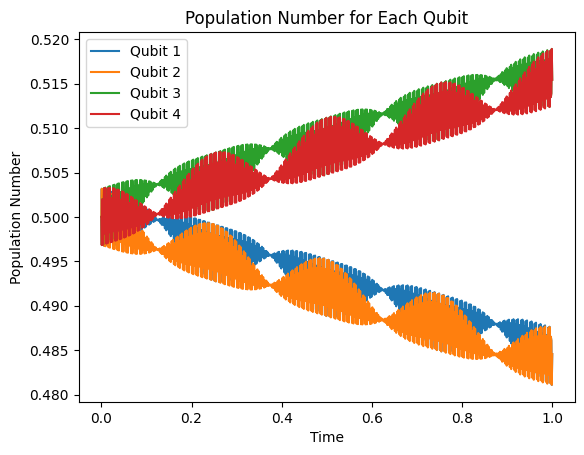

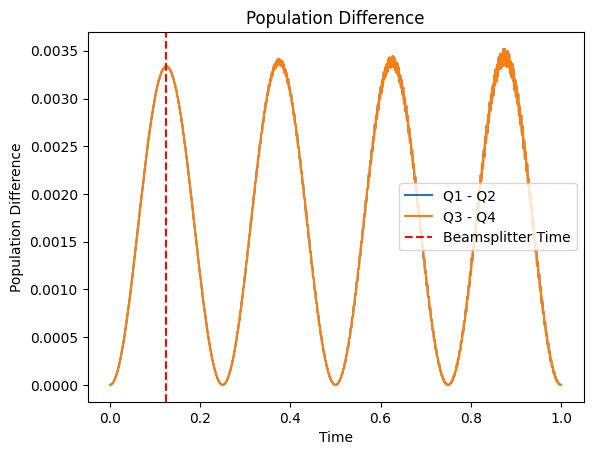

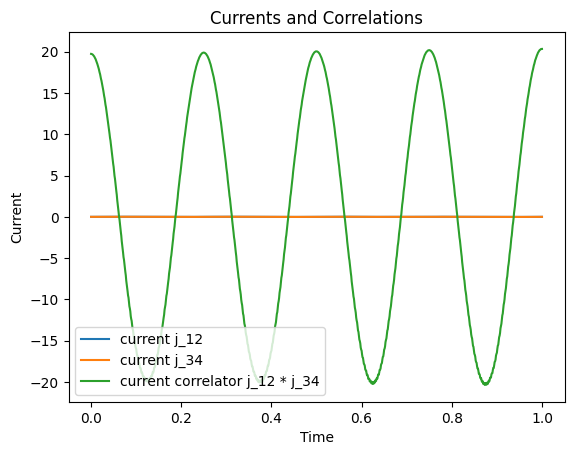

In [228]:
### entangled state on two pairs of qubits

psi0 = (qt.basis([num_levels] * num_qubits, [0, 0, 1, 1]) + 1j*qt.basis([num_levels] * num_qubits, [1, 0, 0, 1]) + 1j*qt.basis([num_levels] * num_qubits, [0, 1, 1, 0]) - qt.basis([num_levels] * num_qubits, [1, 1, 0, 0])).unit()

# Time evolution parameters
tlist = np.linspace(0, 1, 1001)  # time from 0 to 10, 200 points

# Observable: number operator for each qubit
number_operators = [op.dag() * op for op in annihilation_operators]

current_operators = [j_12, j_34]
current_correlator = j_12 * j_34

# Run simulation using sesolve
result = qt.sesolve(H_off_resonant, psi0, tlist, e_ops=number_operators + current_operators + [current_correlator])

# Plot population number for each qubit
for idx in range(len(number_operators)):
    populations = result.expect[idx]
    plt.plot(tlist, populations, label=f'Qubit {idx+1}')

plt.xlabel('Time')
plt.ylabel('Population Number')
plt.title('Population Number for Each Qubit')
plt.legend()
plt.show()

# plot population differences Q1 - Q2 and Q3 - Q4
index_pairs = [(0, 1), (2, 3)]
for idx1, idx2 in index_pairs:
    population_diff = result.expect[idx1] - result.expect[idx2]
    plt.plot(tlist, population_diff, label=f'Q{idx1+1} - Q{idx2+1}')

beamsplitter_time = np.pi/4/J
plt.axvline(beamsplitter_time, color='red', linestyle='--', label='Beamsplitter Time')

plt.xlabel('Time')
plt.ylabel('Population Difference')
plt.title('Population Difference')
plt.legend()
plt.show()

for idx in range(len(current_operators)):
    currents = result.expect[idx + len(number_operators)]
    plt.plot(tlist, currents, label=f'current {["j_12", "j_34"][idx]}')

plt.plot(tlist, result.expect[-1], label='current correlator j_12 * j_34')



plt.xlabel('Time')
plt.ylabel('Current')
plt.title('Currents and Correlations')
plt.legend()
plt.show()

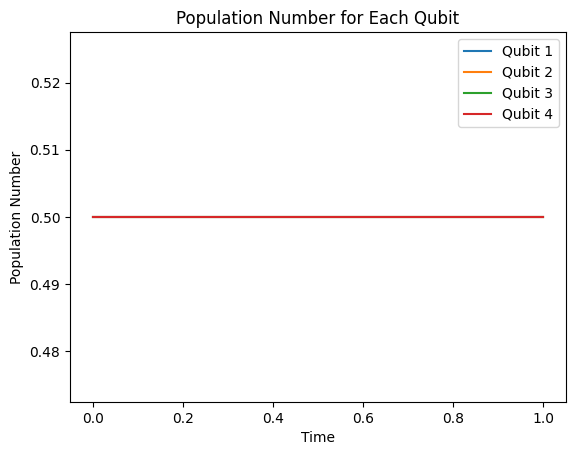

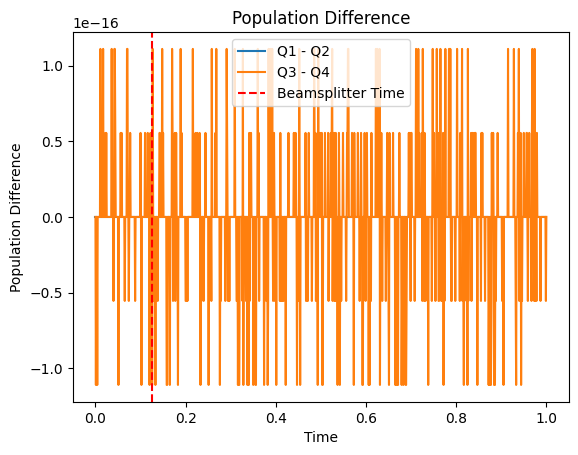

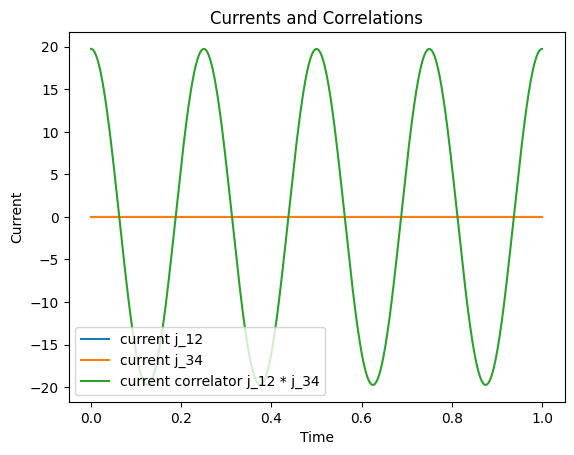

In [229]:
### repeat with uncoupled Hamiltonian

psi0 = (qt.basis([num_levels] * num_qubits, [0, 0, 1, 1]) + 1j*qt.basis([num_levels] * num_qubits, [1, 0, 0, 1]) + 1j*qt.basis([num_levels] * num_qubits, [0, 1, 1, 0]) - qt.basis([num_levels] * num_qubits, [1, 1, 0, 0])).unit()

# Time evolution parameters
tlist = np.linspace(0, 1, 1001)  # time from 0 to 10, 200 points

# Observable: number operator for each qubit
number_operators = [op.dag() * op for op in annihilation_operators]

current_operators = [j_12, j_34]
current_correlator = j_12 * j_34

# Run simulation using sesolve
result = qt.sesolve(H_uncoupled, psi0, tlist, e_ops=number_operators + current_operators + [current_correlator])

# Plot population number for each qubit
for idx in range(len(number_operators)):
    populations = result.expect[idx]
    plt.plot(tlist, populations, label=f'Qubit {idx+1}')

plt.xlabel('Time')
plt.ylabel('Population Number')
plt.title('Population Number for Each Qubit')
plt.legend()
plt.show()

# plot population differences Q1 - Q2 and Q3 - Q4
index_pairs = [(0, 1), (2, 3)]
for idx1, idx2 in index_pairs:
    population_diff = result.expect[idx1] - result.expect[idx2]
    plt.plot(tlist, population_diff, label=f'Q{idx1+1} - Q{idx2+1}')

beamsplitter_time = np.pi/4/J
plt.axvline(beamsplitter_time, color='red', linestyle='--', label='Beamsplitter Time')

plt.xlabel('Time')
plt.ylabel('Population Difference')
plt.title('Population Difference')
plt.legend()
plt.show()

for idx in range(len(current_operators)):
    currents = result.expect[idx + len(number_operators)]
    plt.plot(tlist, currents, label=f'current {["j_12", "j_34"][idx]}')

plt.plot(tlist, result.expect[-1], label='current correlator j_12 * j_34')



plt.xlabel('Time')
plt.ylabel('Current')
plt.title('Currents and Correlations')
plt.legend()
plt.show()

<class 'qutip.core.qobj.Qobj'>


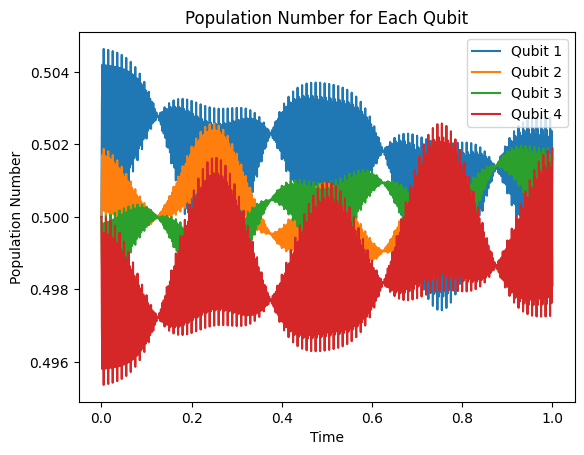

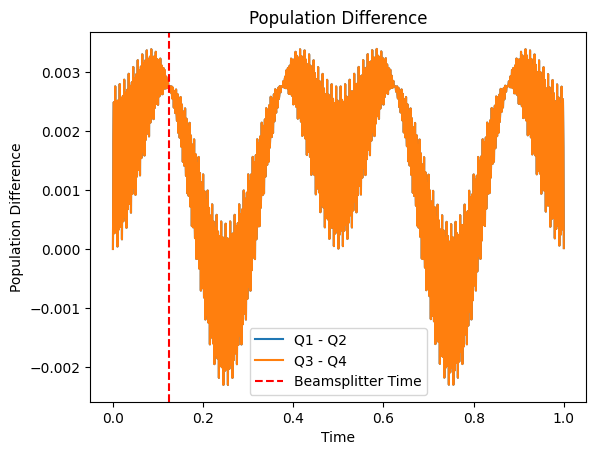

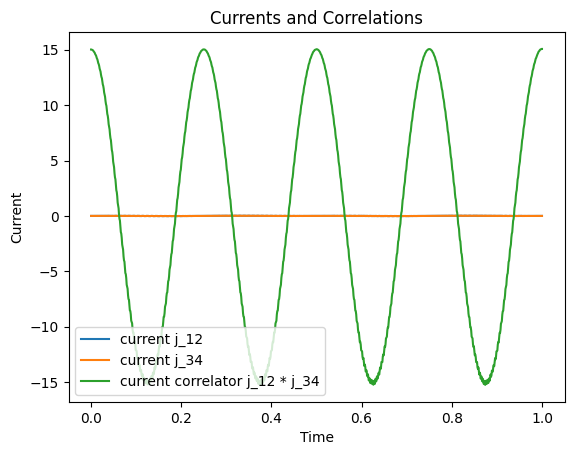

In [ ]:
# eigenstate of resonant hamiltonian with 2 particles

psi0 = highest_energy_eigenstate

# Time evolution parameters
tlist = np.linspace(0, 1, 1001)  # time from 0 to 10, 200 points

# Observable: number operator for each qubit
number_operators = [op.dag() * op for op in annihilation_operators]

current_operators = [j_12, j_34]
current_correlator = j_12 * j_34

# Run simulation using sesolve
result = qt.sesolve(H_off_resonant, psi0, tlist, e_ops=number_operators + current_operators + [current_correlator])

# Plot population number for each qubit
for idx in range(len(number_operators)):
    populations = result.expect[idx]
    plt.plot(tlist, populations, label=f'Qubit {idx+1}')

plt.xlabel('Time')
plt.ylabel('Population Number')
plt.title('Population Number for Each Qubit')
plt.legend()
plt.show()

# plot population differences Q1 - Q2 and Q3 - Q4
index_pairs = [(0, 1), (2, 3)]
for idx1, idx2 in index_pairs:
    population_diff = result.expect[idx1] - result.expect[idx2]
    plt.plot(tlist, population_diff, label=f'Q{idx1+1} - Q{idx2+1}')

beamsplitter_time = np.pi/4/J
plt.axvline(beamsplitter_time, color='red', linestyle='--', label='Beamsplitter Time')

plt.xlabel('Time')
plt.ylabel('Population Difference')
plt.title('Population Difference')
plt.legend()
plt.show()

for idx in range(len(current_operators)):
    currents = result.expect[idx + len(number_operators)]
    plt.plot(tlist, currents, label=f'current {["j_12", "j_34"][idx]}')

plt.plot(tlist, result.expect[-1], label='current correlator j_12 * j_34')



plt.xlabel('Time')
plt.ylabel('Current')
plt.title('Currents and Correlations')
plt.legend()
plt.show()

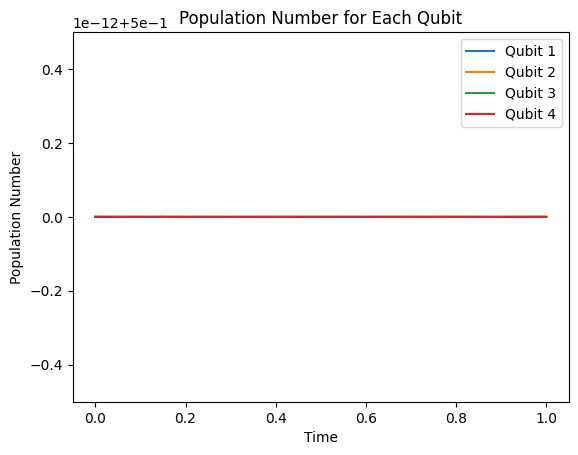

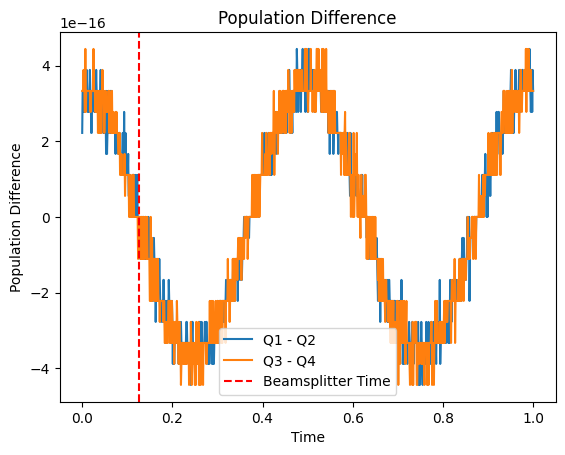

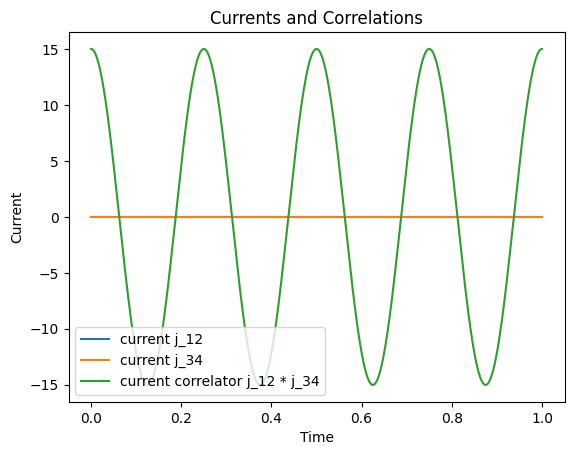

In [32]:
# repeat with uncoupled Hamiltonian

psi0 = highest_energy_eigenstate

# Time evolution parameters
tlist = np.linspace(0, 1, 1001)  # time from 0 to 10, 200 points

# Observable: number operator for each qubit
number_operators = [op.dag() * op for op in annihilation_operators]

current_operators = [j_12, j_34]
current_correlator = j_12 * j_34

# Run simulation using sesolve
result = qt.sesolve(H_uncoupled, psi0, tlist, e_ops=number_operators + current_operators + [current_correlator])

# Plot population number for each qubit
for idx in range(len(number_operators)):
    populations = result.expect[idx]
    plt.plot(tlist, populations, label=f'Qubit {idx+1}')

plt.xlabel('Time')
plt.ylabel('Population Number')
plt.title('Population Number for Each Qubit')
plt.legend()
plt.show()

# plot population differences Q1 - Q2 and Q3 - Q4
index_pairs = [(0, 1), (2, 3)]
for idx1, idx2 in index_pairs:
    population_diff = result.expect[idx1] - result.expect[idx2]
    plt.plot(tlist, population_diff, label=f'Q{idx1+1} - Q{idx2+1}')

beamsplitter_time = np.pi/4/J
plt.axvline(beamsplitter_time, color='red', linestyle='--', label='Beamsplitter Time')

plt.xlabel('Time')
plt.ylabel('Population Difference')
plt.title('Population Difference')
plt.legend()
plt.show()

for idx in range(len(current_operators)):
    currents = result.expect[idx + len(number_operators)]
    plt.plot(tlist, currents, label=f'current {["j_12", "j_34"][idx]}')

plt.plot(tlist, result.expect[-1], label='current correlator j_12 * j_34')



plt.xlabel('Time')
plt.ylabel('Current')
plt.title('Currents and Correlations')
plt.legend()
plt.show()

## Simulating Individual Shot Data

Instead of just expectation values, we can simulate individual measurement outcomes using Monte Carlo methods. This gives us the actual 0/1 measurement results for each qubit on each shot.

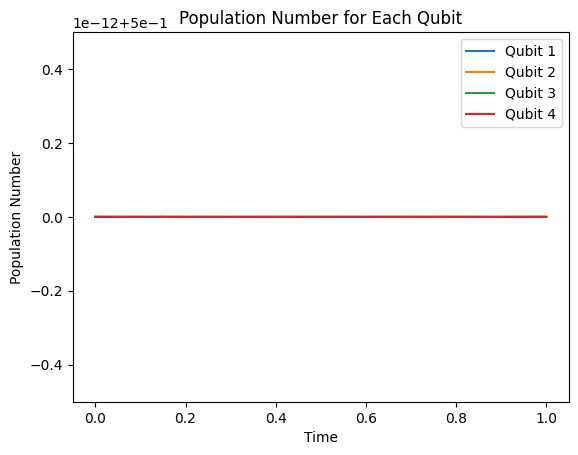

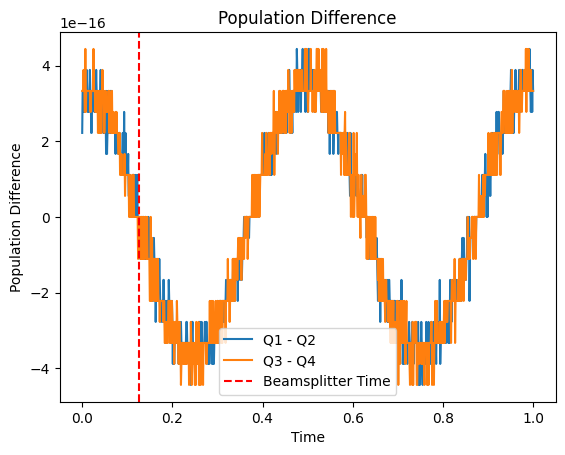

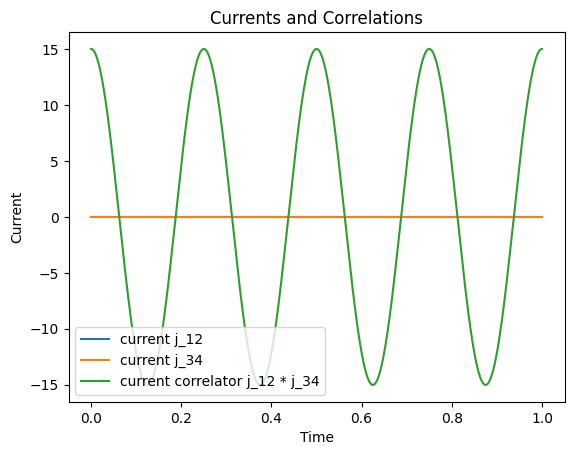

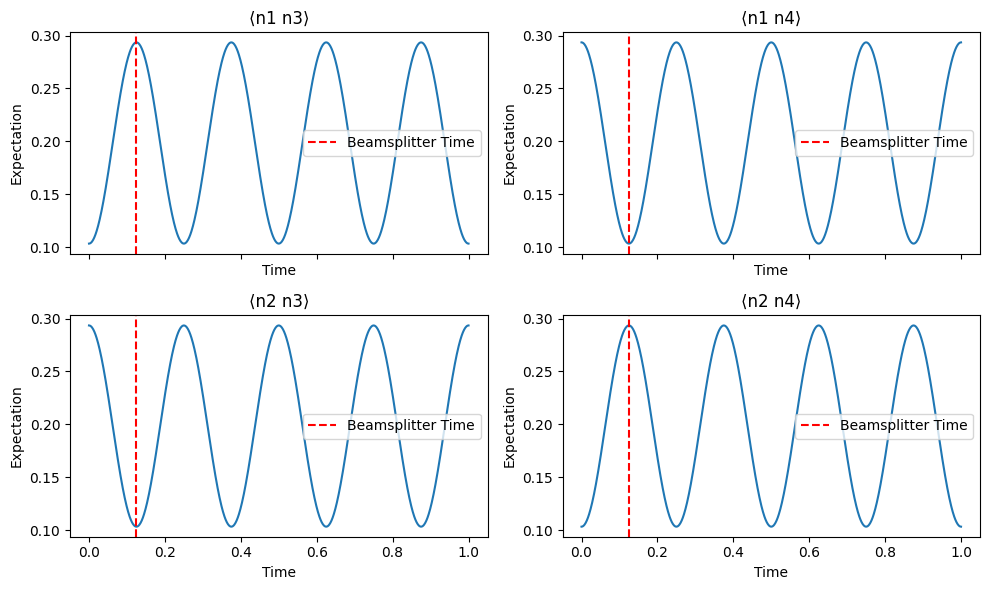

In [59]:
# repeat with uncoupled Hamiltonian

psi0 = highest_energy_eigenstate
simulation_Hamiltonian = H_uncoupled

# Time evolution parameters
tlist = np.linspace(0, 1, 1001)  # time from 0 to 10, 200 points

# Observable: number operator for each qubit
number_operators = [op.dag() * op for op in annihilation_operators]

current_operators = [j_12, j_34]
current_correlator = j_12 * j_34

# Run simulation using sesolve
result = qt.sesolve(simulation_Hamiltonian, psi0, tlist)

populations = [qt.expect(op, result.states) for op in number_operators]
currents = [qt.expect(op, result.states) for op in current_operators]
current_correlator_expectation = qt.expect(current_correlator, result.states)

# Plot population number for each qubit
for idx in range(len(number_operators)):
    plt.plot(tlist, populations[idx], label=f'Qubit {idx+1}')

plt.xlabel('Time')
plt.ylabel('Population Number')
plt.title('Population Number for Each Qubit')
plt.legend()
plt.show()

# plot population differences Q1 - Q2 and Q3 - Q4
index_pairs = [(0, 1), (2, 3)]
for idx1, idx2 in index_pairs:
    population_diff = populations[idx1] - populations[idx2]
    plt.plot(tlist, population_diff, label=f'Q{idx1+1} - Q{idx2+1}')

beamsplitter_time = np.pi/4/J
plt.axvline(beamsplitter_time, color='red', linestyle='--', label='Beamsplitter Time')

plt.xlabel('Time')
plt.ylabel('Population Difference')
plt.title('Population Difference')
plt.legend()
plt.show()

for idx in range(len(current_operators)):
    plt.plot(tlist, currents[idx], label=f'current {["j_12", "j_34"][idx]}')

plt.plot(tlist, current_correlator_expectation, label='current correlator j_12 * j_34')



plt.xlabel('Time')
plt.ylabel('Current')
plt.title('Currents and Correlations')
plt.legend()
plt.show()


number_correlators = []
correlator_pairs = [(0,2), (0,3), (1,2), (1,3)]
for idx1, idx2 in correlator_pairs:
    number_correlator = number_operators[idx1] * number_operators[idx2]
    number_correlators.append(number_correlator)

    # Calculate expectation values for number correlators
    number_correlator_expectations = [qt.expect(op, result.states) for op in number_correlators]

# plot number correlators
fig, axs = plt.subplots(2, 2, figsize=(10, 6), sharex=True)
labels = ['⟨n1 n3⟩', '⟨n1 n4⟩', '⟨n2 n3⟩', '⟨n2 n4⟩']
for i, ax in enumerate(axs.flat):
    ax.plot(tlist, number_correlator_expectations[i])
    ax.set_title(labels[i])
    ax.set_xlabel('Time')
    ax.set_ylabel('Expectation')
    ax.axvline(beamsplitter_time, color='red', linestyle='--', label='Beamsplitter Time')
    ax.legend()
plt.tight_layout()
plt.show()


In [50]:
def quantum_state_to_bitstring(quantum_state, num_levels, num_qubits):
    # Find the index of the nonzero entry
    idx = int(np.argmax(np.abs(quantum_state.full())))
    # Convert the index to a bitstring
    bitstring = []
    for _ in range(num_qubits):
        bitstring.append(idx % num_levels)
        idx //= num_levels
    return bitstring[::-1]


# I can map a bitstring to a quantum state as follows
bitstring = [1, 1, 0, 0]  # Example bitstring
quantum_state = qt.basis([num_levels] * num_qubits, bitstring)

print(f'original bitstring: {bitstring}')
print(f'quantum state: {quantum_state}')

# Example usage:
bitstring_recovered = quantum_state_to_bitstring(quantum_state, num_levels, num_qubits)
print(f'recovered bitstring: {bitstring_recovered}')





original bitstring: [1, 1, 0, 0]
quantum state: Quantum object: dims=[[2, 2, 2, 2], [1, 1, 1, 1]], shape=(16, 1), type='ket', dtype=Dense
Qobj data =
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]]
recovered bitstring: [1, 1, 0, 0]


In [56]:
from itertools import product

### simulate projective measurement

num_levels = 2

# first construct every measurement outcome for 4 qubits with 2 levels
basis_states = []
for state in product(range(num_levels), repeat=num_qubits):
    if all(x in (0, 1) for x in state):
        basis_states.append(qt.basis([num_levels] * num_qubits, list(state)))


shots = 500
projectors = [state * state.dag() for state in basis_states]

population_shots = np.zeros([num_levels]*num_qubits + [len(tlist), shots])
print(f'population_shots shape: {population_shots.shape}')

# simulate projective measurement
for i in range(len(result.states)):
    state = result.states[i]
    print(f'timestep {i}')
    # print(f"State at time {tlist[i]}:")
    for j in range(shots):
        # for k, projector in enumerate(projectors):
        #     probability = qt.expect(projector, state)
        #     if probability > 0:
        #         print(f"  Probability of outcome {quantum_state_to_bitstring(basis_states[k], num_levels, num_qubits)}: {probability:.4f}")
        
        # Simulate a projective measurement
        outcome_index = np.random.choice(len(projectors), p=[qt.expect(projector, state) for projector in projectors])
        outcome_state = basis_states[outcome_index]
        outcome_bitstring = [int(qt.expect(op, outcome_state)) for op in number_operators]

        population_shots[tuple(outcome_bitstring) + (i, j)] += 1

        # print(f"  Projective measurement outcome: {outcome_bitstring}")

population_shots shape: (2, 2, 2, 2, 1001, 500)
timestep 0
timestep 1
timestep 2
timestep 3
timestep 4
timestep 5
timestep 6
timestep 7
timestep 8
timestep 9
timestep 10
timestep 11
timestep 12
timestep 13
timestep 14
timestep 15
timestep 16
timestep 17
timestep 18
timestep 19
timestep 20
timestep 21
timestep 22
timestep 23
timestep 24
timestep 25
timestep 26
timestep 27
timestep 28
timestep 29
timestep 30
timestep 31
timestep 32
timestep 33
timestep 34
timestep 35
timestep 36
timestep 37
timestep 38
timestep 39
timestep 40
timestep 41
timestep 42
timestep 43
timestep 44
timestep 45
timestep 46
timestep 47
timestep 48
timestep 49
timestep 50
timestep 51
timestep 52
timestep 53
timestep 54
timestep 55
timestep 56
timestep 57
timestep 58
timestep 59
timestep 60
timestep 61
timestep 62
timestep 63
timestep 64
timestep 65
timestep 66
timestep 67
timestep 68
timestep 69
timestep 70
timestep 71
timestep 72
timestep 73
timestep 74
timestep 75
timestep 76
timestep 77
timestep 78
timestep 79
ti

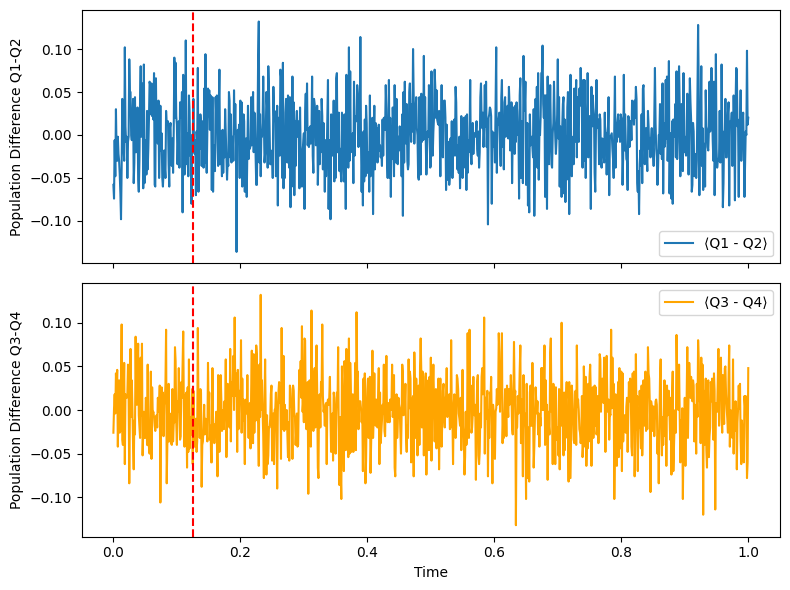

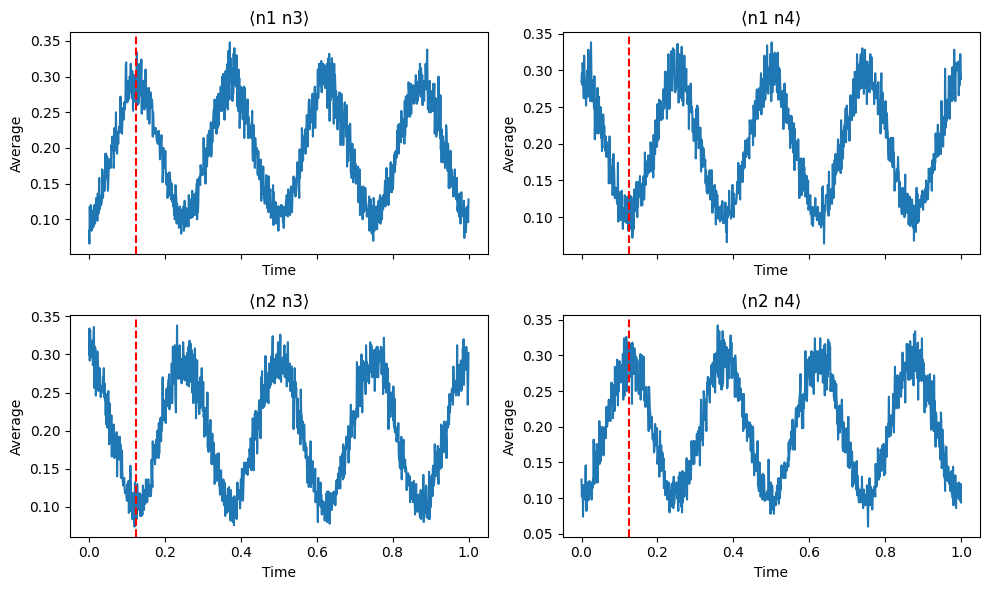

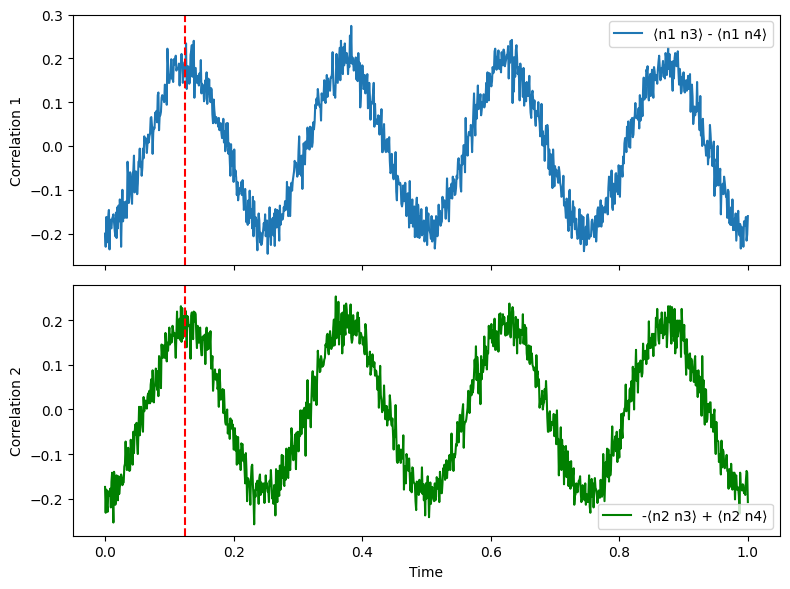

In [58]:
# Get dimensions
_, _, _, _, num_times, num_shots = population_shots.shape

# Prepare arrays for averages
avg_pop_diff_12 = np.zeros(num_times)
avg_pop_diff_34 = np.zeros(num_times)

avg_n1n3 = np.zeros(num_times)
avg_n1n4 = np.zeros(num_times)
avg_n2n3 = np.zeros(num_times)
avg_n2n4 = np.zeros(num_times)

# Loop over time
for t in range(num_times):
    # For each shot, get bitstrings and compute quantities
    pop_diff_12 = []
    pop_diff_34 = []
    n1n3 = []
    n1n4 = []
    n2n3 = []
    n2n4 = []
    for n in range(num_shots):
        # Find all bitstrings with count > 0 at this time and shot
        # Since each shot is a single outcome, only one bitstring will have count==1
        idx = np.argwhere(population_shots[:, :, :, :, t, n] == 1)
        if idx.size == 0:
            continue
        i, j, k, l = idx[0]
        # Population difference Q1-Q2, Q3-Q4
        pop_diff_12.append(i - j)
        pop_diff_34.append(k - l)
        # Correlators
        n1n3.append(i * k)
        n1n4.append(i * l)
        n2n3.append(j * k)
        n2n4.append(j * l)
    # Average over shots
    avg_pop_diff_12[t] = np.mean(pop_diff_12)
    avg_pop_diff_34[t] = np.mean(pop_diff_34)
    avg_n1n3[t] = np.mean(n1n3)
    avg_n1n4[t] = np.mean(n1n4)
    avg_n2n3[t] = np.mean(n2n3)
    avg_n2n4[t] = np.mean(n2n4)

beamsplitter_time = np.pi/4/J


# Plot population differences
fig, axs = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
axs[0].plot(tlist[:num_times], avg_pop_diff_12, label='⟨Q1 - Q2⟩')
axs[0].set_ylabel('Population Difference Q1-Q2')
axs[0].legend()
axs[1].plot(tlist[:num_times], avg_pop_diff_34, label='⟨Q3 - Q4⟩', color='orange')
axs[1].set_ylabel('Population Difference Q3-Q4')
axs[1].set_xlabel('Time')
axs[1].legend()
for ax in axs.flat:
    ax.axvline(beamsplitter_time, color='red', linestyle='--', label='Beamsplitter Time')


plt.tight_layout()
plt.show()

# Plot correlators
fig, axs = plt.subplots(2, 2, figsize=(10, 6), sharex=True)
axs[0, 0].plot(tlist[:num_times], avg_n1n3)
axs[0, 0].set_title('⟨n1 n3⟩')
axs[0, 1].plot(tlist[:num_times], avg_n1n4)
axs[0, 1].set_title('⟨n1 n4⟩')
axs[1, 0].plot(tlist[:num_times], avg_n2n3)
axs[1, 0].set_title('⟨n2 n3⟩')
axs[1, 1].plot(tlist[:num_times], avg_n2n4)
axs[1, 1].set_title('⟨n2 n4⟩')
for ax in axs.flat:
    ax.set_xlabel('Time')
    ax.set_ylabel('Average')

    ax.axvline(beamsplitter_time, color='red', linestyle='--', label='Beamsplitter Time')
plt.tight_layout()
plt.show()

# Plot correlation quantities
corr1 = avg_n1n3 - avg_n1n4
corr2 = -avg_n2n3 + avg_n2n4

fig, axs = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
axs[0].plot(tlist[:num_times], corr1, label='⟨n1 n3⟩ - ⟨n1 n4⟩')
axs[0].set_ylabel('Correlation 1')
axs[0].legend()
axs[1].plot(tlist[:num_times], corr2, label='-⟨n2 n3⟩ + ⟨n2 n4⟩', color='green')
axs[1].set_ylabel('Correlation 2')
axs[1].set_xlabel('Time')
axs[1].legend()
for ax in axs.flat:
    ax.axvline(beamsplitter_time, color='red', linestyle='--', label='Beamsplitter Time')
plt.tight_layout()
plt.show()

In [63]:
H_uncoupled

Quantum object: dims=[[2, 2, 2, 2], [2, 2, 2, 2]], shape=(16, 16), type='oper', dtype=Dia, isherm=True
Qobj data =
[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         6.28318531 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         6.28318531 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         6.28318531 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.  

In [61]:
print(convert_to_reduced_hamiltonian(H_uncoupled, num_levels, num_qubits, 1))

(0, 0, 0, 1)
(0, 0, 1, 0)
(0, 1, 0, 0)
(1, 0, 0, 0)
Quantum object: dims=[[4], [4]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.         6.28318531 0.         0.        ]
 [6.28318531 0.         0.         0.        ]
 [0.         0.         0.         6.28318531]
 [0.         0.         6.28318531 0.        ]]


# 3.

In [48]:
import importlib
import src.src_current_measurement_simulations

importlib.reload(src.src_current_measurement_simulations);
from src.src_current_measurement_simulations import CurrentMeasurementSimulation

In [42]:
num_levels = 3
num_qubits = 4
num_particles = 2

initial_detunings = np.array([2, 4, -2, 4]) * 2 * np.pi  # MHz
initial_detunings = np.array([0]*4) * 2 * np.pi  # MHz

measurement_detuning = np.array([310, 310, -280, -280]) * 2 * np.pi  # MHz

readout_pair_1 = [0,1]
readout_pair_2 = [2,3]

J = -1.0 * 2 * np.pi
J_parallel = 1.0 * 2 * np.pi

J = -np.array([6.74, 5.9, 5.79]) * 2 * np.pi # MHz
# J = -np.array([5, 5, 7]) * 2 * np.pi # MHz
J = -np.array([1, 1, 1]) * 2 * np.pi # MHz

J_parallel = -np.array([5.1, 5.38]) * 2 * np.pi # MHz
J_parallel = np.array([1, 1]) * 2 * np.pi # MHz


# pi flux
J = -np.array([6.74, 5.9, 5.79]) * 2 * np.pi # MHz
J_parallel = -np.array([7.25, 7.65]) * 2 * np.pi # MHz

U = -200 * 2 * np.pi
U = -20 * 2 * np.pi

times = np.linspace(0, 0.2, 1001) # microseconds
# times = np.linspace(0, 1, 1001) # microseconds

use_time_offset = False

coupling_1 = 0
if abs(readout_pair_1[0] - readout_pair_1[1]) == 1:
    coupling_1 = J[min(readout_pair_1[0], readout_pair_1[1])]
elif abs(readout_pair_1[0] - readout_pair_1[1]) == 2:
    coupling_1 = J_parallel[min(readout_pair_1[0], readout_pair_1[1])]

coupling_2 = 0
if abs(readout_pair_2[0] - readout_pair_2[1]) == 1:
    coupling_2 = J[min(readout_pair_2[0], readout_pair_2[1])]
elif abs(readout_pair_2[0] - readout_pair_2[1]) == 2:
    coupling_2 = J_parallel[min(readout_pair_2[0], readout_pair_2[1])]

t_BS_1 = abs(np.pi/4/coupling_1)
t_BS_2 = abs(np.pi/4/coupling_2)

print(f'qubits {readout_pair_1[0]+1} and {readout_pair_1[1]+1}:')
print(f'\tcoupling: {coupling_1/2/np.pi} MHz')
print(f'\tbeamsplitter time: {t_BS_1} us')

print(f'qubits {readout_pair_2[0]+1} and {readout_pair_2[1]+1}:')
print(f'\tcoupling: {coupling_2/2/np.pi} MHz')
print(f'\tbeamsplitter time: {t_BS_2} us')


time_offset = 0
if use_time_offset:
    time_offset = t_BS_2 - t_BS_1

print()
print(f'time offset between beamsplitters: {time_offset} us')

psi0 = 'highest_single_particle'
psi0 = None
# psi0 = new_state

psi0 = -1


qubits 1 and 2:
	coupling: -6.74 MHz
	beamsplitter time: 0.018545994065281898 us
qubits 3 and 4:
	coupling: -5.789999999999999 MHz
	beamsplitter time: 0.021588946459412783 us

time offset between beamsplitters: 0 us


In [43]:
current_measurement_simulation = CurrentMeasurementSimulation(num_levels, num_qubits, num_particles, J, J_parallel, U, times, readout_pair_1, readout_pair_2, initial_detunings=initial_detunings, measurement_detuning=measurement_detuning, psi0=psi0, time_offset=time_offset)

# current_measurement_simulation.print_initial_Hamiltonian()
# current_measurement_simulation.print_measurement_Hamiltonian()
# current_measurement_simulation.print_uncoupled_Hamiltonian()




In [44]:
# # try more complicated initial state

# one_particle_eigenstates = current_measurement_simulation.get_particle_number_to_eigenstate_dict()[1]
# two_particle_eigenstates = current_measurement_simulation.get_particle_number_to_eigenstate_dict()[2]

# # try prepare |0001> but actually get |0>|0>|theta_1, phi_1>|theta_2, phi_2>
# # |theta_i, phi_i> = cos(theta_i/2) |0> + exp(i*phi_i) sin(theta_i/2) |1>

# # |0000> -> vacuum state
# # |0001> -> current_measurement_simulation.get_particle_number_to_eigenstate()[1][-1]
# # |0010> -> current_measurement_simulation.get_particle_number_to_eigenstate()[1][-2]
# # |0011> -> current_measurement_simulation.get_particle_number_to_eigenstate()[2][-1]

# theta_1 = 9/10 * np.pi
# phi_1 = np.pi/2

# theta_2 = 9/10*np.pi
# phi_2 = np.pi/2

# theta_1 = 1/2 * np.pi
# phi_1 = np.pi/2

# theta_2 = 1/2 * np.pi
# phi_2 = np.pi/2

# # vacuum state
# # theta_1 = 0
# # theta_2 = 0

# # full eigenstate
# # theta_1 = np.pi
# # theta_2 = np.pi


# prepared_state = 0
# prepared_state += np.cos(theta_1/2)*np.cos(theta_2/2) * qt.basis([num_levels] * num_qubits, [0, 0, 0, 0])  # |0000> 
# prepared_state += np.cos(theta_1/2)*np.sin(theta_2/2) * np.exp(1j*phi_2) * one_particle_eigenstates[-1]  # |0001> 
# prepared_state += np.sin(theta_1/2)*np.cos(theta_2/2) * np.exp(1j*phi_1) * one_particle_eigenstates[-2]  # |0010> 
# prepared_state += np.sin(theta_1/2)*np.sin(theta_2/2) * np.exp(1j*(phi_1 + phi_2)) * two_particle_eigenstates[-1]  # |0011> 


# print(f"Norm of prepared_state: {prepared_state.norm()}")
# print(f'prepared state: {prepared_state}')

# total_number_operator = np.sum([op.dag() * op for op in current_measurement_simulation.annihilation_operators])
# particle_number = np.round(qt.expect(total_number_operator, prepared_state))
# print(f'particle number of prepared state: {particle_number}')

# current_measurement_simulation.psi0 = prepared_state


In [45]:
# # psi0 = current_measurement_simulation.psi0

# print(f'original: {psi0}')

# # use qutip to time evolve psi0 slightly
# H = generate_triangle_lattice_Hamiltonian(current_measurement_simulation.annihilation_operators, current_measurement_simulation.J, current_measurement_simulation.J_parallel, current_measurement_simulation.U, [300*2*np.pi, 0, 0, 0])

# idle_time = 0.5e-3 # ns

# # Use QuTiP's propagator to compute the unitary evolution operator
# unitary = qt.propagator(H, idle_time)


# new_state = unitary * psi0

# print(f'new state:')

# new_state

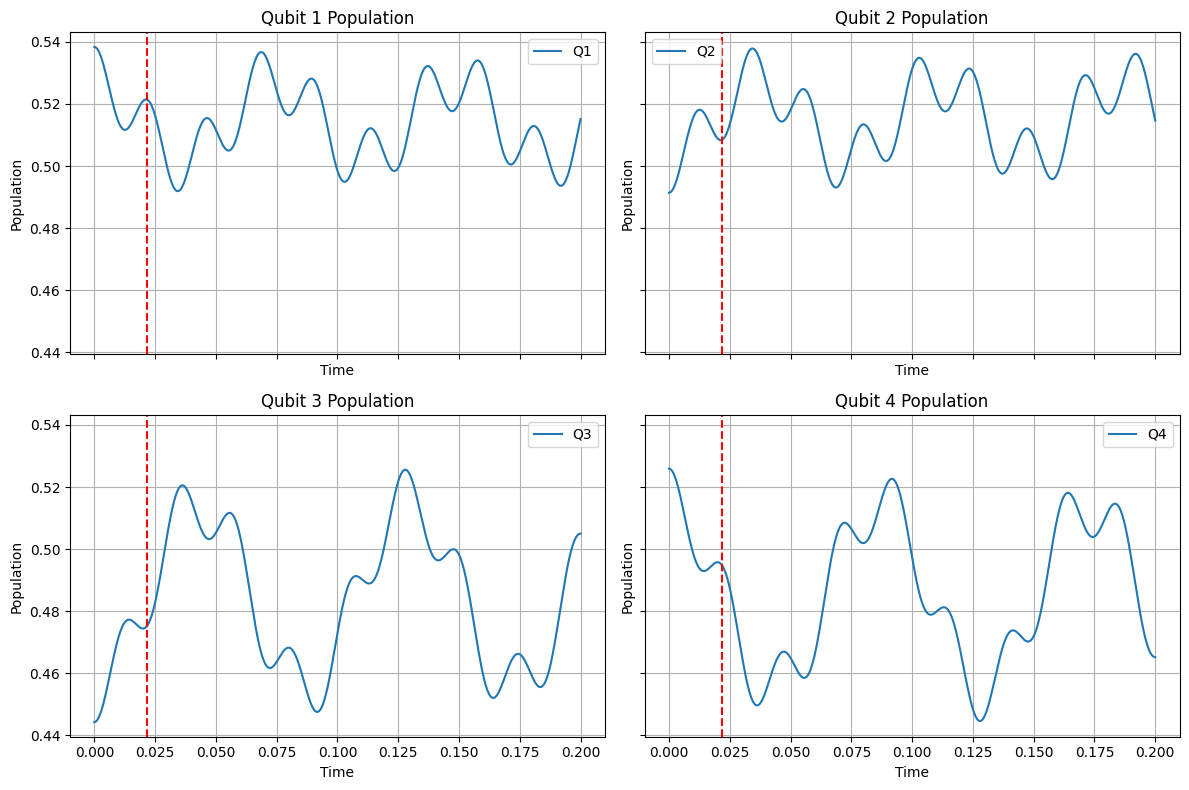

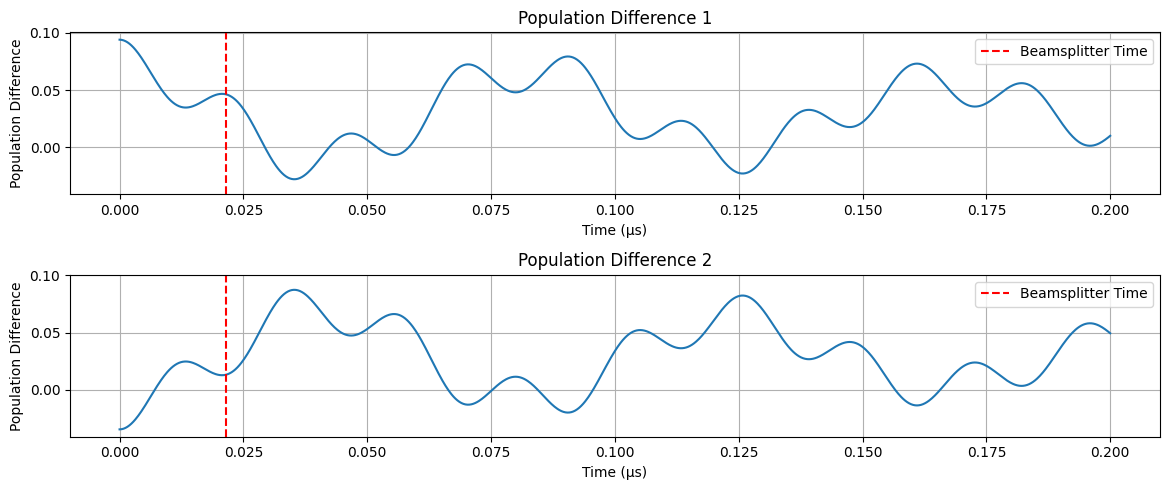

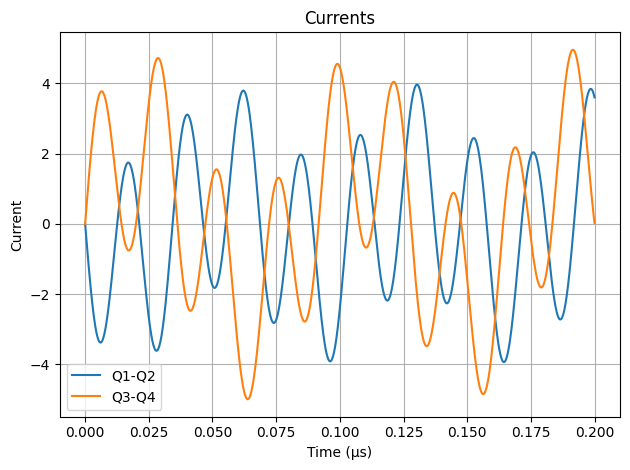

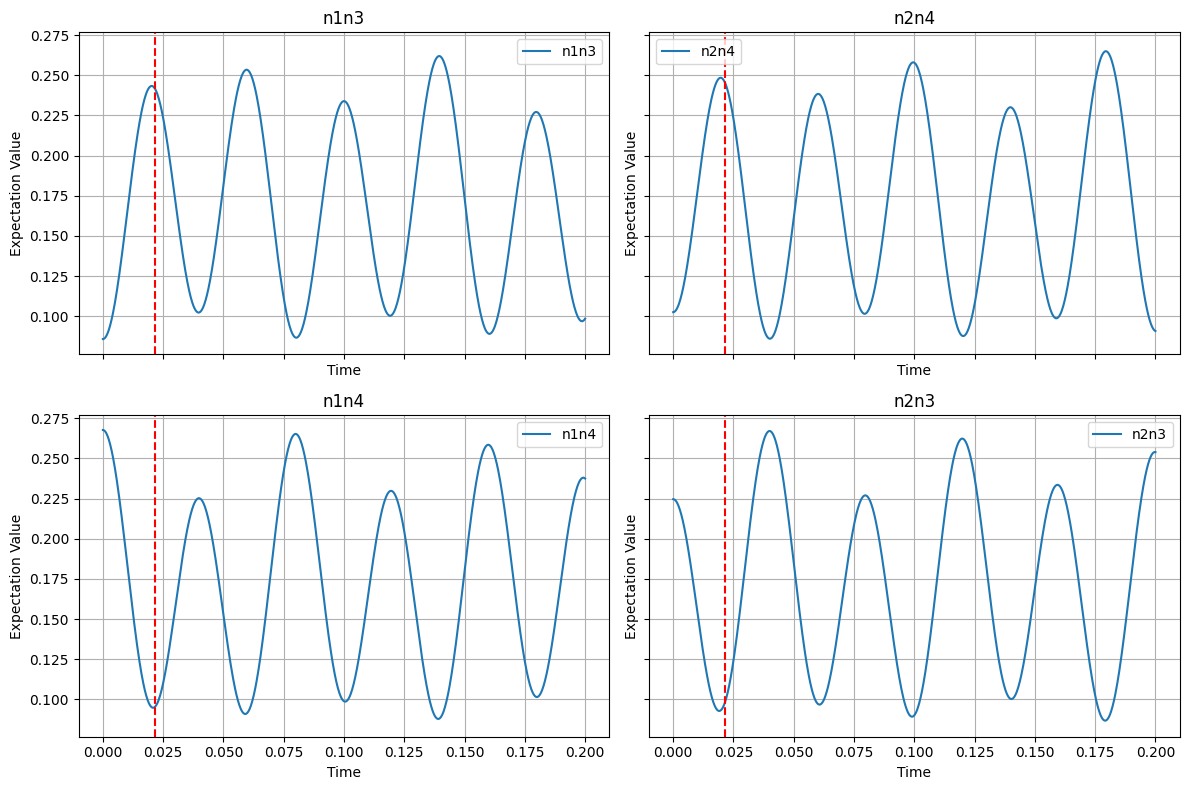

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


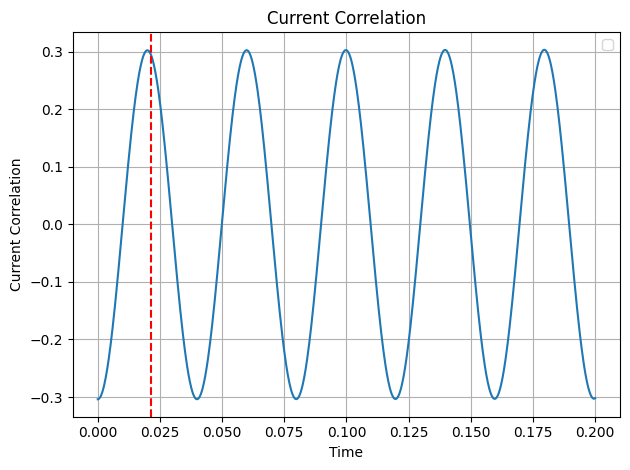

In [46]:
current_measurement_simulation.run_simulation(True)
# current_measurement_simulation.run_simulation(False)
current_measurement_simulation.plot_populations(plot_beamsplitter_time=True)
current_measurement_simulation.plot_population_difference(plot_beamsplitter_time=True)
current_measurement_simulation.plot_currents()

current_measurement_simulation.plot_n_terms(plot_beamsplitter_time=True)
current_measurement_simulation.plot_current_correlation(plot_beamsplitter_time=True)

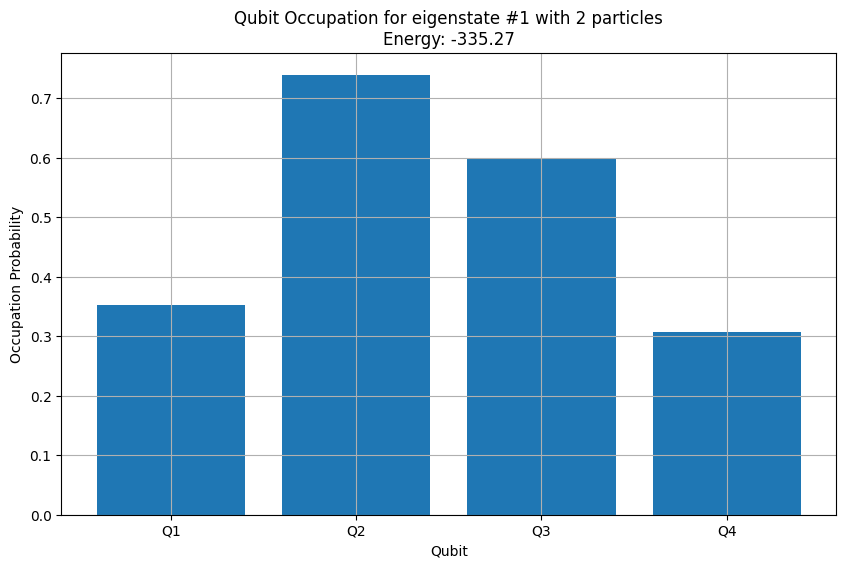

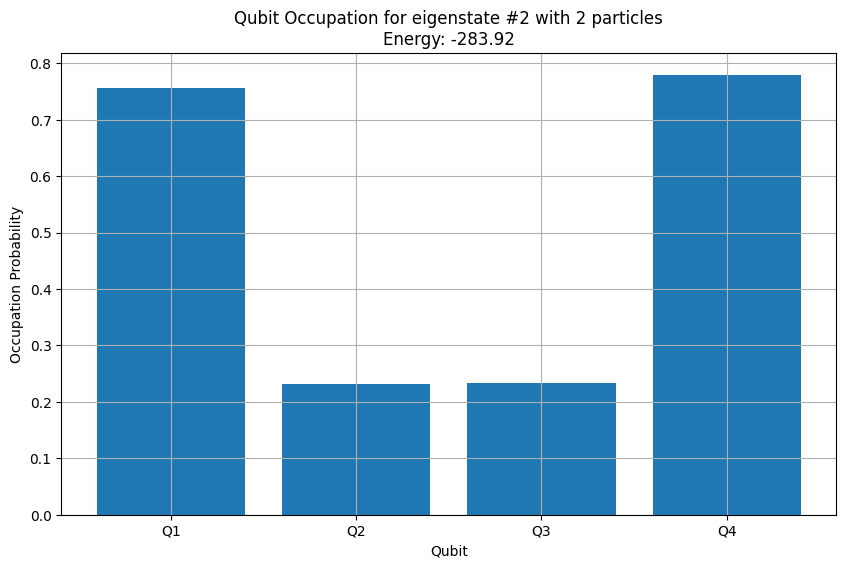

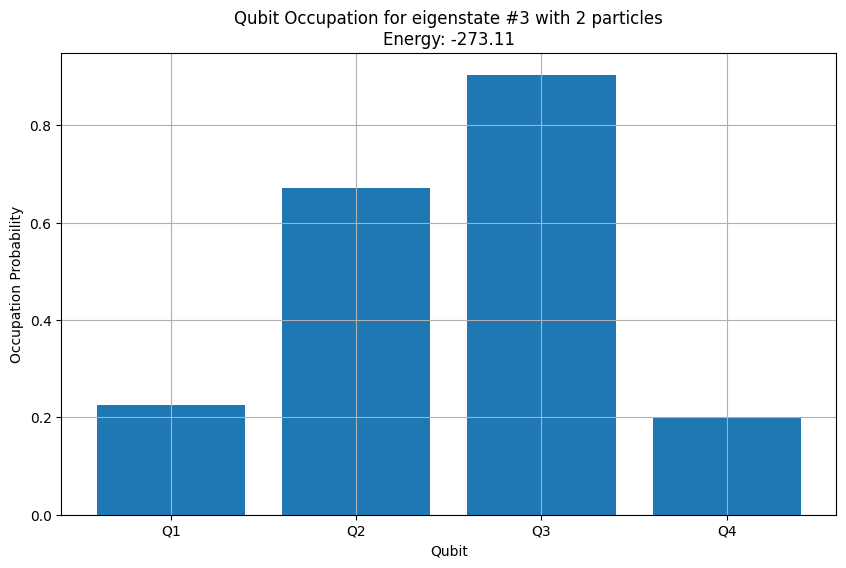

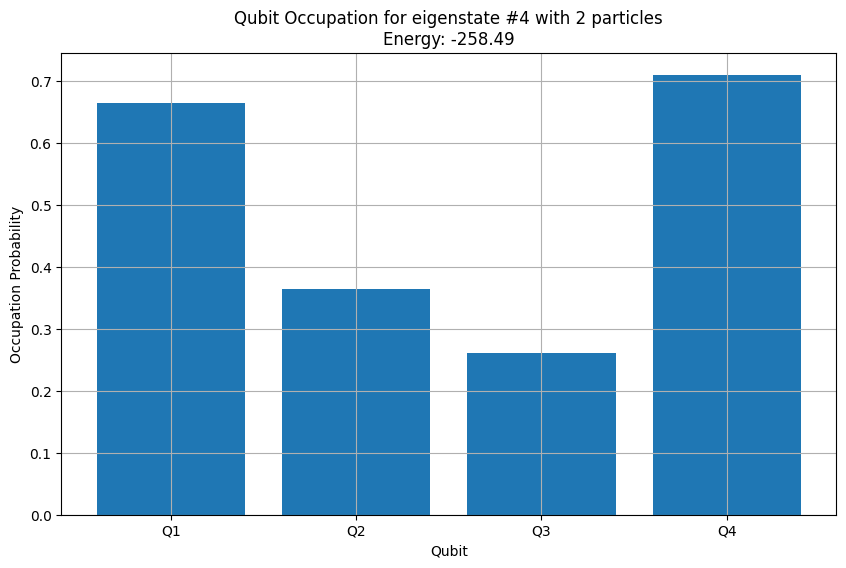

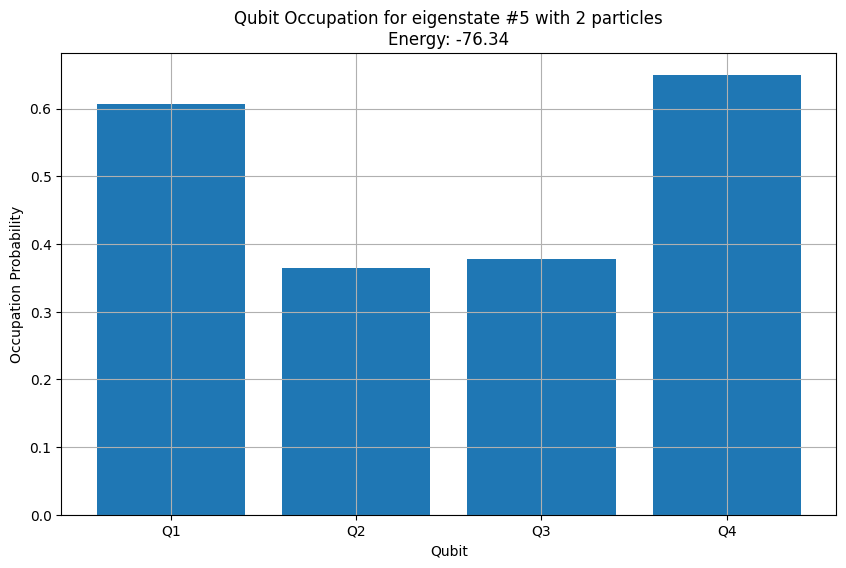

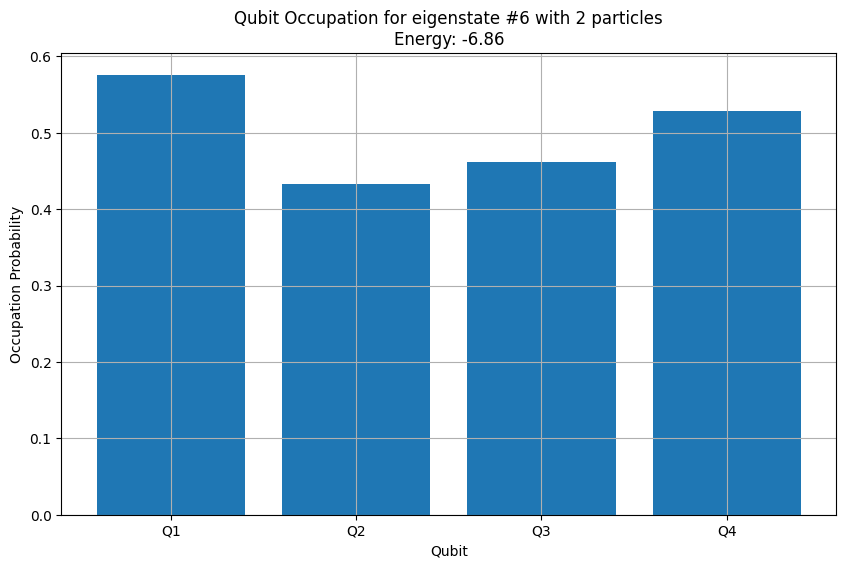

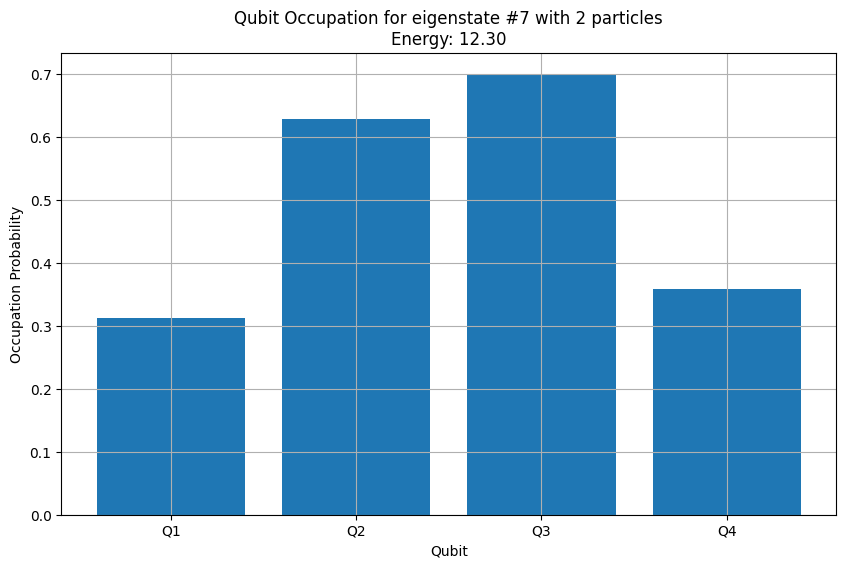

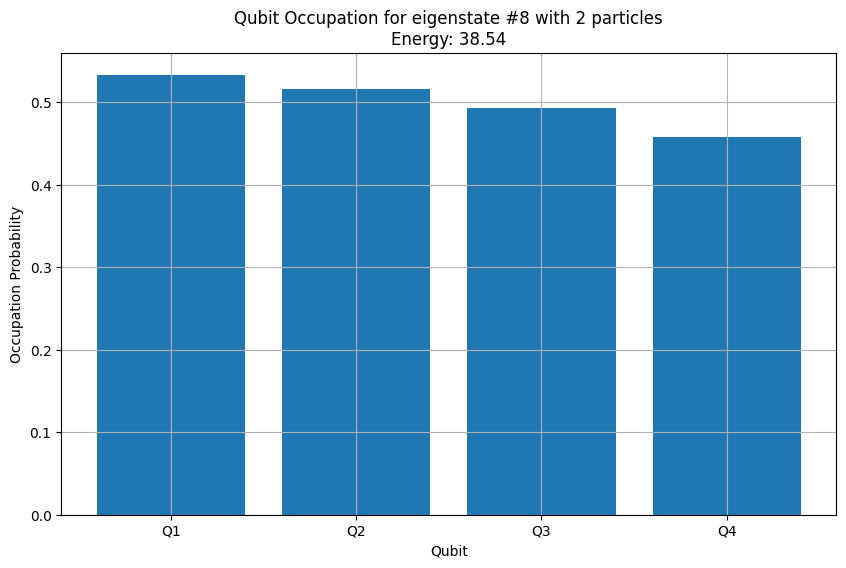

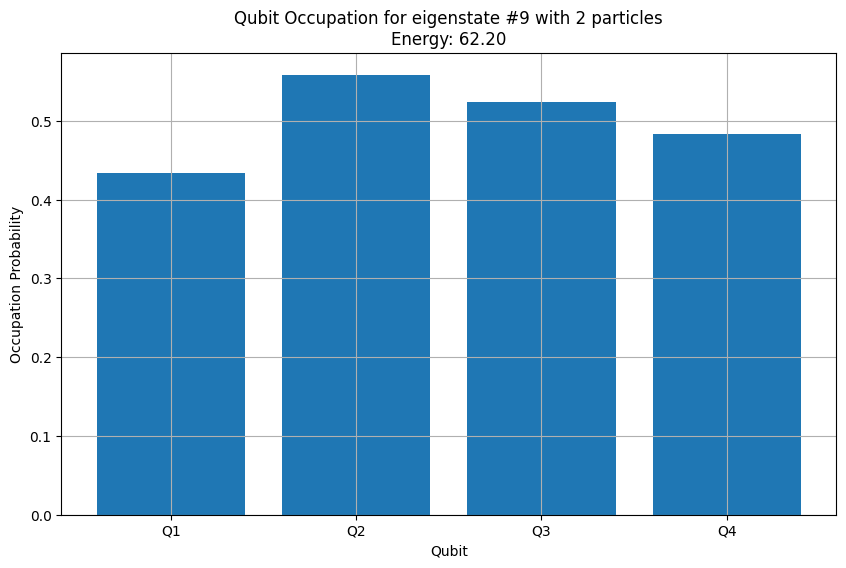

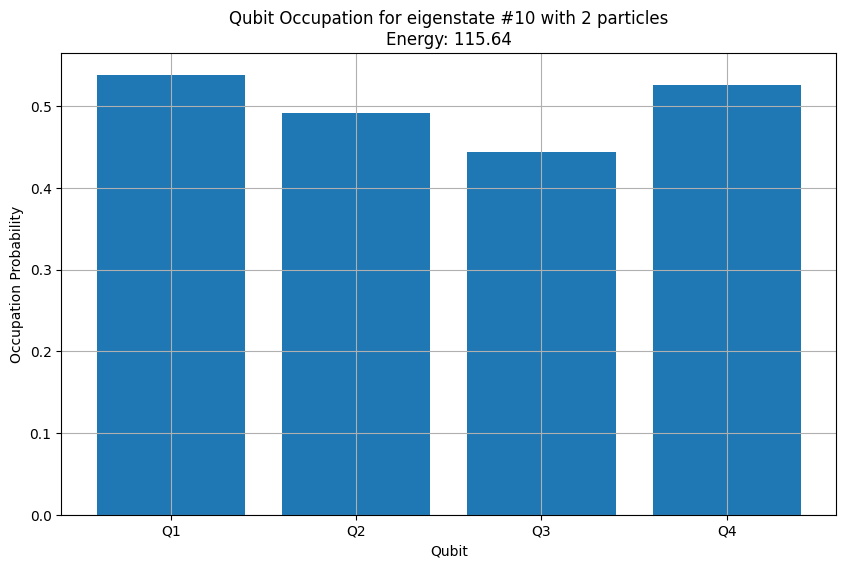

In [47]:
# plot eigenstates

current_measurement_simulation.plot_eigenstates(particle_number=2)

### 3.2 Analyze Reduced Density Matrix

In [8]:
psi = current_measurement_simulation.psi0
print(f'psi0: {psi}')

print(f'number of particles: {qt.expect(total_number_operator, psi)}')

psi0: Quantum object: dims=[[2, 2, 2, 2], [1, 1, 1, 1]], shape=(16, 1), type='ket', dtype=Dense
Qobj data =
[[ 0.00000000e+00]
 [ 2.52101895e-18]
 [ 4.15220470e-17]
 [ 2.89007665e-01]
 [-3.71218357e-17]
 [ 3.68679151e-01]
 [-4.54543973e-01]
 [ 0.00000000e+00]
 [ 1.11022302e-16]
 [-5.89065136e-01]
 [ 1.82182782e-01]
 [ 2.26252786e-18]
 [ 4.40172386e-01]
 [-8.00564338e-18]
 [ 1.68056800e-18]
 [ 0.00000000e+00]]


NameError: name 'total_number_operator' is not defined

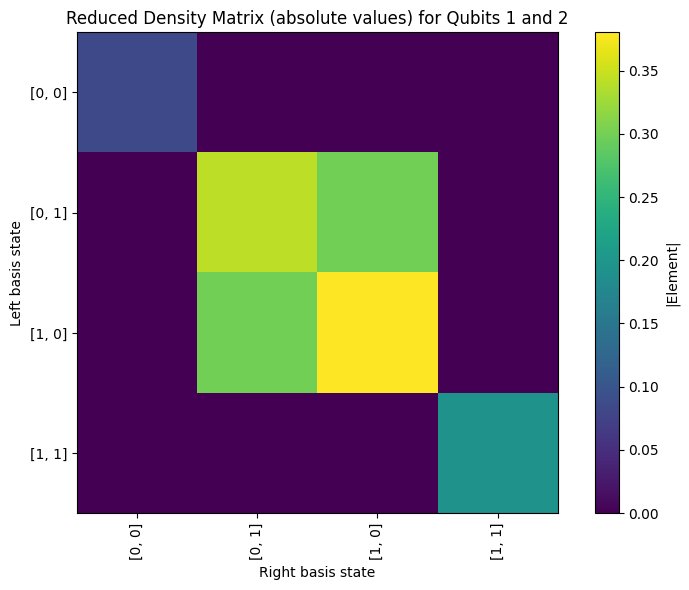

In [9]:
# calculate reduced density matrix for the first two qubits
reduced_density_matrix = qt.ptrace(psi, [0, 1])

# Plot histogram of the matrix elements of the reduced density matrix
import matplotlib.pyplot as plt

reduced_density_matrix_array = np.zeros_like(reduced_density_matrix.full())

# Iterate through basis tuples for the first two qubits (00, 01, 02, 10, 11, 12, 20, 21, 22)
basis_lists = [[i, j] for i in range(num_levels) for j in range(num_levels)]

for i in range(len(basis_lists)):
    left_state = qt.basis([num_levels] * 2, basis_lists[i])
    for j in range(len(basis_lists)):
        right_state = qt.basis([num_levels] * 2, basis_lists[j])
        reduced_density_matrix_array[i, j] = left_state.dag()*reduced_density_matrix*right_state
                                        

fig, ax = plt.subplots(figsize=(8, 6))
x_labels = [str(b) for b in basis_lists]
y_labels = [str(b) for b in basis_lists]

# Plot absolute values as 2D bar chart (color mesh)
im = ax.imshow(np.abs(reduced_density_matrix_array), cmap='viridis')

# Set axis labels
ax.set_xticks(np.arange(len(x_labels)))
ax.set_yticks(np.arange(len(y_labels)))
ax.set_xticklabels(x_labels, rotation=90)
ax.set_yticklabels(y_labels)

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('|Element|')

ax.set_xlabel('Right basis state')
ax.set_ylabel('Left basis state')
ax.set_title('Reduced Density Matrix (absolute values) for Qubits 1 and 2')
plt.tight_layout()
plt.show()

In [13]:
annihilation_operators_2Q = []

annihilation_operators_2Q.append(qt.tensor(qt.destroy(num_levels), qt.qeye(num_levels))) 
annihilation_operators_2Q.append(qt.tensor(qt.qeye(num_levels), qt.destroy(num_levels))) 

a1, a2 = annihilation_operators_2Q
H_2Q = J[0] * (a1.dag() * a2 + a2.dag() * a1) + U/2*(a1.dag()*a1*(a1.dag()*a1 - 1) + a2.dag()*a2*(a2.dag()*a2 - 1))

total_number_operator_2Q = a1.dag() * a1 + a2.dag() * a2
# H_2Q*total_number_operator_2Q - total_number_operator_2Q*H_2Q

H_2Q


Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dia, isherm=True
Qobj data =
[[  0.           0.           0.           0.        ]
 [  0.           0.         -42.34866897   0.        ]
 [  0.         -42.34866897   0.           0.        ]
 [  0.           0.           0.           0.        ]]

In [14]:
reduced_density_matrix.tr()

qt.expect(reduced_density_matrix, total_number_operator_2Q)

1.1102262989887053

In [20]:
annihilation_operators_2Q[1].dag() * annihilation_operators_2Q[1]

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dia, isherm=True
Qobj data =
[[0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 1.]]

In [27]:
result = qt.mesolve(H_2Q, reduced_density_matrix, times)

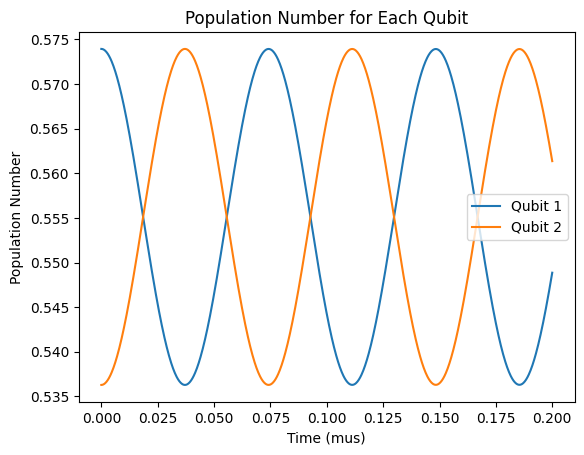

In [30]:
populations = []
for i in range(len(annihilation_operators_2Q)):
    a = annihilation_operators_2Q[i]
    populations.append([qt.expect(a.dag() * a, state) for state in result.states])

for i in range(len(annihilation_operators_2Q)):
    plt.plot(times, populations[i], label=f'Qubit {i+1}')

# plt.plot(times, qt.expect(total_number_operator_2Q, result.states), label='Total Population')

plt.xlabel('Time (mus)')
plt.ylabel('Population Number')
plt.title('Population Number for Each Qubit')
plt.legend()
plt.show()

